In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/'
emotion_to_index = {'Positive':1, 'Neutral':2, 'Negative':3}

In [3]:
import os
import csv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict
import os
import random
import numpy as np
from tqdm import tqdm
import time
import pickle

import cv2

%matplotlib inline

In [4]:
import tensorflow
import pathlib
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten, LSTM, Activation, MaxPooling2D
from tensorflow.keras.regularizers import l2 as L2_reg
from tensorflow.keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D, Input, Masking, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.optimizers import SGD, Adam

print(tf.__version__)

2.4.1


In [5]:
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

# Feature extraction

## Extract frames

In [23]:
for s in ['Val', 'Train']:
    d=os.path.join(DATA_DIR,s)
    for filename in os.listdir(d):
        outd=os.path.join(DATA_DIR,'preprocessed',s,'frames',str(os.path.splitext(filename)[0]))
        if not os.path.exists(outd):
            os.mkdir(outd)
        command = "ffmpeg -r 1 -i " + os.path.join(d,filename) + " -r 1 '" + outd + "/%04d.png'"
        print(command)
        os.system(command=command)

## Detect faces in frames

#### MTCNN

In [6]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False,minsize=64) #32) #

In [21]:
scale=1
def save_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            for image in os.listdir(os.path.join(source_path, folder)):
                filename = os.path.join(source_path, folder, image)
                print(filename)
                frame_bgr = cv2.imread(filename)
                frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                #frame=cv2.resize(frame, (0,0), fx=1/scale, fy=1/scale) 
                bounding_boxes, _ = imgProcessing.detect_faces(frame)

                if len(bounding_boxes)!=0:
                    root,ext=os.path.splitext(image)
                    faces_folder=os.path.join(save_path, folder, root) 
                    if not os.path.exists(faces_folder):
                        os.mkdir(faces_folder)
                    for i,bounding_box in enumerate(bounding_boxes):
                        outfile=os.path.join(faces_folder, str(i)+ext)
                        if not os.path.exists(outfile):
                            bounding_box*=scale
                            b=[max(0,int(bi)) for bi in bounding_box]
                            x1,y1,x2,y2=b[0:4]
                            face_img=frame_bgr[y1:y2,x1:x2,:]

                            if np.prod(face_img.shape)==0:
                                print('Empty face ',b,' found for ',filename)
                                continue
                            #face_img=cv2.resize(face_img,INPUT_SIZE)
                            cv2.imwrite(outfile, face_img) 
        else:
            print(folder)
        
save_faces(os.path.join(DATA_DIR,'preprocessed/Val/frames'),os.path.join(DATA_DIR,'preprocessed/Val/mtcnn'))
save_faces(os.path.join(DATA_DIR,'preprocessed/Train/frames'),os.path.join(DATA_DIR,'preprocessed/Train/mtcnn'))

#### Aligned

In [8]:
import numpy as np
import cv2
import math
from skimage import transform as trans

def preprocess(img, bbox=None, landmark=None, **kwargs):
    M = None
    image_size = [224,224]
    src = np.array([
      [30.2946, 51.6963],
      [65.5318, 51.5014],
      [48.0252, 71.7366],
      [33.5493, 92.3655],
      [62.7299, 92.2041] ], dtype=np.float32 )
    if image_size[1]==224:
        src[:,0] += 8.0
    src*=2
    if landmark is not None:
        dst = landmark.astype(np.float32)

        tform = trans.SimilarityTransform()
        #dst=dst[:3]
        #src=src[:3]
        #print(dst.shape,src.shape,dst,src)
        tform.estimate(dst, src)
        M = tform.params[0:2,:]
        #M = cv2.estimateRigidTransform( dst.reshape(1,5,2), src.reshape(1,5,2), False)
        #print(M)

    if M is None:
        if bbox is None: #use center crop
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1]*0.0625)
            det[1] = int(img.shape[0]*0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
              det = bbox
        margin = kwargs.get('margin', 44)
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin//2, 0)
        bb[1] = np.maximum(det[1]-margin//2, 0)
        bb[2] = np.minimum(det[2]+margin//2, img.shape[1])
        bb[3] = np.minimum(det[3]+margin//2, img.shape[0])
        ret = img[bb[1]:bb[3],bb[0]:bb[2],:]
        if len(image_size)>0:
              ret = cv2.resize(ret, (image_size[1], image_size[0]))
        return ret 
    else: #do align using landmark
        assert len(image_size)==2
        warped = cv2.warpAffine(img,M,(image_size[1],image_size[0]), borderValue = 0.0)
        return warped


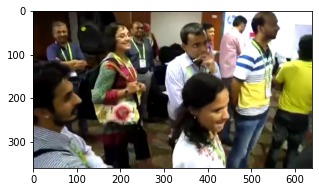

<Figure size 360x360 with 0 Axes>

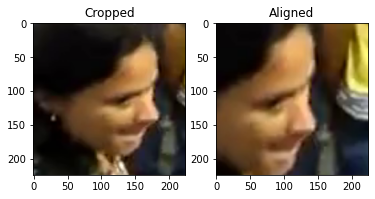

<Figure size 360x360 with 0 Axes>

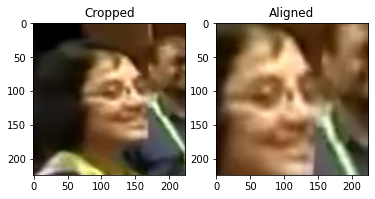

<Figure size 360x360 with 0 Axes>

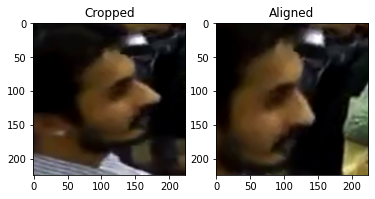

<Figure size 360x360 with 0 Axes>

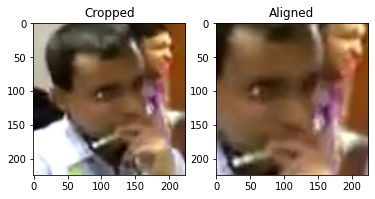

<Figure size 360x360 with 0 Axes>

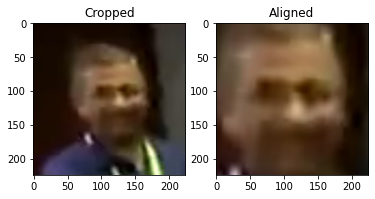

In [9]:
import matplotlib.pyplot as plt
fpath='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/preprocessed/Val/frames/289_55/0001.png'
#fpath='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/preprocessed/Val/frames/5_2/0001.png'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
#frame=cv2.resize(frame, (0,0), fx=1, fy=1) 
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    #face_img=frame[y1:y2,x1:x2,:]

    #face_img=extract_image_chip(frame,p)
    p = p.reshape((2,5)).T
        
    plt.figure(figsize=(5, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    face_img=preprocess(frame,box,None) #p)
    ax1.set_title('Cropped')
    ax1.imshow(face_img)
    
    face_img=preprocess(frame,box,p)
    ax2.set_title('Aligned')
    ax2.imshow(face_img)

In [ ]:
def save_aligned_faces(source_path,save_path):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for folder in tqdm(os.listdir(source_path)):
        if not os.path.exists(os.path.join(save_path, folder)):
            os.mkdir(os.path.join(save_path, folder))

            for image in os.listdir(os.path.join(source_path, folder)):
                filename = os.path.join(source_path, folder, image)
                #print(filename)
                frame_bgr = cv2.imread(filename)
                frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
                bounding_boxes, points = imgProcessing.detect_faces(frame)
                points = points.T

                if len(bounding_boxes)!=0:
                    root,ext=os.path.splitext(image)
                    faces_folder=os.path.join(save_path, folder, root) 
                    if not os.path.exists(faces_folder):
                        os.mkdir(faces_folder)
                    for i,b in enumerate(bounding_boxes):
                        outfile=os.path.join(faces_folder, str(i)+ext)
                        if not os.path.exists(outfile):
                            p=points[i]
                            if True: #not USE_RETINA_FACE:
                                p = p.reshape((2,5)).T
                            face_img=preprocess(frame_bgr,b,p)

                            if np.prod(face_img.shape)==0:
                                print('Empty face ',b,' found for ',filename)
                                continue
                            cv2.imwrite(outfile, face_img) 
        else:
            print(folder)
        
save_aligned_faces(os.path.join(DATA_DIR,'preprocessed/Val/frames'),os.path.join(DATA_DIR,'preprocessed/Val/mtcnn_aligned'))
save_aligned_faces(os.path.join(DATA_DIR,'preprocessed/Train/frames'),os.path.join(DATA_DIR,'preprocessed/Train/mtcnn_aligned'))


 25%|██▍       | 660/2661 [3:15:46<9:16:43, 16.69s/it] 

### Batch processing and multiple features 

In [6]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import load_model,Model

In [7]:
base_model=load_model('../models/affectnet_emotions/mobilenet_7.h5')
feature_extractor_model=Model(base_model.input,[base_model.get_layer('global_pooling').output,base_model.get_layer('feats').output,base_model.output])
feature_extractor_model.summary()
_,w,h,_=feature_extractor_model.input.shape
print(w,h)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [8]:
feature_extractor_model.output

[<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'global_pooling')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'feats')>,
 <KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'emotion_preds')>]

In [9]:
def mobilenet_preprocess_input(x,**kwargs):
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

preprocessing_function=mobilenet_preprocess_input

In [ ]:
def get_features_scores(data_dir):
    videoname2features={}
    for videoname in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,videoname)
        X_global_features,X_feats,X_scores=[],[],[]
        for filename in sorted(os.listdir(frames_dir)):
            faces_dir=os.path.join(frames_dir,filename)
            imgs=[]
            for img_name in sorted(os.listdir(faces_dir)):
                #print(img_name)
                img=cv2.imread(os.path.join(faces_dir,img_name))

                if img.size:
                    img=cv2.resize(img,(w,h))
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                    imgs.append(img)

            if len(imgs)>0:        
                inp = preprocessing_function(np.array(imgs, dtype=np.float32))
                global_features,feats,scores=feature_extractor_model.predict(inp)
                #print(videoname,filename,global_features.shape,feats.shape,scores.shape)
                X_global_features.append(global_features)
                X_feats.append(feats)
                X_scores.append(scores)
        
        #print(videoname,len(X_global_features))
        videoname2features[videoname]=(X_global_features,X_feats,X_scores)
    return videoname2features

video2Allfeatures_val=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Val/mtcnn_aligned'))
video2Allfeatures_train=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Train/mtcnn_aligned'))

### Save/load features 

In [12]:
#model_name='mobilenet_v1_ft'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf.pickle' #'_feat_bgr_emotiw.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_cropped.pickle'
MODEL2EMOTIW_FEATURES='mymobilenet_7_ft_sgd_model_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_vgaf_aligned.pickle'
print(MODEL2EMOTIW_FEATURES)

mymobilenet_7_ft_sgd_model_feat_vgaf_aligned.pickle


In [99]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([video2Allfeatures_train,video2Allfeatures_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
del video2Allfeatures_train,video2Allfeatures_val

In [13]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    video2Allfeatures_train,video2Allfeatures_val=pickle.load(handle)
print(len(video2Allfeatures_train),len(video2Allfeatures_val))

2661 766


In [14]:
def create_dataset(videoname2features,labelsfile):
    x = []
    y = []
    has_faces=[]
    ind=0
    with open(labelsfile, mode='r') as csvfile:
        labels_reader = csv.reader(csvfile, delimiter=' ')
        for i,row in enumerate(labels_reader):
            if i==0:
                #print('first:',row)
                continue
            videoname,label=row[0],int(row[1])
            if MODEL2EMOTIW_FEATURES.startswith('enet0'):
                X_global_features=videoname2features[videoname]
            else:
                X_global_features,X_feats,X_scores=videoname2features[videoname]
            #print(videoname,label,len(X_global_features))
            
            total_features=[]
            for cur_features in X_global_features:
                #print(cur_features.shape)
                if False:
                    total_features.extend(cur_features)
                else:
                    mean_features = (np.mean(cur_features, axis=0))
                    std_features = (np.std(cur_features, axis=0))
                    max_features = (np.max(cur_features, axis=0))
                    min_features = (np.min(cur_features, axis=0))

                    # join several features together
                    #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                    #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                    #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                    feature = np.concatenate((mean_features,std_features), axis=None)
                    #feature = np.concatenate((max_features,mean_features,std_features), axis=None)
                    #feature=max_features

                    total_features.append(feature)
            
            if len(total_features)>0:
                total_features=np.array(total_features)
                mean_features = (np.mean(total_features, axis=0))
                std_features = (np.std(total_features, axis=0))
                max_features = (np.max(total_features, axis=0))
                min_features = (np.min(total_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature = np.concatenate((max_features,std_features), axis=None)
                #feature=std_features
                x.append(feature)
                has_faces.append(1)
            else:
                x.append(np.zeros_like(feature))
                has_faces.append(0)
            y.append(label-1)
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(video2Allfeatures_train,os.path.join(DATA_DIR,'Train_labels.txt'))
x_test, y_test, has_faces_test = create_dataset(video2Allfeatures_val,os.path.join(DATA_DIR,'Val_labels.txt'))

(2661, 4096) (2661,)
(766, 4096) (766,)


In [15]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [17]:
#clf = svm.LinearSVC(C=0.1)
clf = svm.SVC(kernel='rbf',C=1)
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if False:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7031039136302294
Complete accuracy: 0.6892950391644909
